In [31]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="aJYHYdVJLfR1sQPVAwwE")
project = rf.workspace("fona").project("food-detection-yvcmw")
dataset = project.version(10).download("multiclass")
dataset.location

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Food-Detection-10 in multiclass:: 100%|██████████| 3504/3504 [00:04<00:00, 831.97it/s] 


'/content/Food-Detection-10'

In [55]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.style as style
import keras
import numpy as np
import PIL.Image as Image

from sklearn.metrics import multilabel_confusion_matrix

base = https://github.com/ashrefm/multi-label-soft-f1/blob/master/Multi-Label%20Image%20Classification%20in%20TensorFlow%202.0.ipynb

# Setup

In [33]:
IMG_SIZE = 224 # 200 - 600an
CHANNELS = 3
BATCH_SIZE = 4 # Big enough to measure an F1-score

AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

LR = 1e-3 # Keep it small when transfer learning
EPOCHS = 50

tfhub_model_url = 'https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/140-224-feature-vector/versions/2'

model_name = 'Prototype02_B'

# Preprocessing

In [34]:
train_df = pd.read_csv(os.path.join(dataset.location, 'train', '_classes.csv'))
valid_df = pd.read_csv(os.path.join(dataset.location, 'valid', '_classes.csv'))

for i, trial in train_df.iterrows():
  train_df.loc[i, "filename"] = os.path.join(dataset.location, "train", train_df.loc[i, "filename"])

for i, trial in valid_df.iterrows():
  valid_df.loc[i, "filename"] = os.path.join(dataset.location, "valid", valid_df.loc[i, "filename"])

x_train = list(train_df['filename'])
x_valid = list(valid_df['filename'])
x_train[:3]

['/content/Food-Detection-10/train/oseng_mie-065_jpg.rf.0036680924bd1e5cbb18921a8bb49afb.jpg',
 '/content/Food-Detection-10/train/IMG_20220324_192021_BURST050_jpg.rf.0017493d01ca14f674b04dfe27ad043d.jpg',
 '/content/Food-Detection-10/train/images41_jpg.rf.006b90d3a3a38b71157d14a8ac8b1721.jpg']

In [35]:
y_train = train_df.drop(columns=['filename']).to_numpy()
y_valid = valid_df.drop(columns=['filename']).to_numpy()
y_train[:3]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]])

In [36]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [37]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

In [38]:
train_ds = create_dataset(x_train, y_train)
val_ds = create_dataset(x_valid, y_valid, is_training=False)

for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (4, 224, 224, 3)
Shape of labels array: (4, 29)


# Model Building

In [39]:
import tensorflow_hub as hub

feature_extractor_url = tfhub_model_url
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

feature_extractor_layer.trainable = False

In [40]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal',
                               input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),

])

In [41]:
model = tf.keras.Sequential([
    data_augmentation,
    feature_extractor_layer,
    tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
    tf.keras.layers.Dense(29, activation='sigmoid', name='output') # jangan diganti
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1792)              4363712   
                                                                 
 hidden_layer (Dense)        (None, 1024)              1836032   
                                                                 
 output (Dense)              (None, 29)                29725     
                                                                 
Total params: 6229469 (23.76 MB)
Trainable params: 1865757 (7.12 MB)
Non-trainable params: 4363712 (16.65 MB)
_________________________________________________________________


In [42]:
# for batch in train_ds:
#     print(model.predict(batch[0])[:1])
#     # print(batch[0])
#     break

In [43]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.

    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)

    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [44]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)

    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive

    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [45]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1],
  )

# Model Training

In [46]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    # min_lr=1e-6
)

In [47]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[lr_callback]
                    )

Epoch 1/50
714/714 [==============================] - 79s 21ms/step - loss: 0.9073 - macro_f1: 0.0926 - val_loss: 0.9127 - val_macro_f1: 0.0875 - lr: 0.0010
Epoch 2/50
714/714 [==============================] - 10s 14ms/step - loss: 0.8855 - macro_f1: 0.1151 - val_loss: 0.9173 - val_macro_f1: 0.0829 - lr: 0.0010
Epoch 3/50
714/714 [==============================] - 9s 13ms/step - loss: 0.8784 - macro_f1: 0.1214 - val_loss: 0.9040 - val_macro_f1: 0.0967 - lr: 0.0010
Epoch 4/50
714/714 [==============================] - 10s 14ms/step - loss: 0.8733 - macro_f1: 0.1269 - val_loss: 0.9052 - val_macro_f1: 0.0946 - lr: 0.0010
Epoch 5/50
714/714 [==============================] - 10s 14ms/step - loss: 0.8714 - macro_f1: 0.1286 - val_loss: 0.9047 - val_macro_f1: 0.0961 - lr: 0.0010
Epoch 6/50
714/714 [==============================] - 10s 14ms/step - loss: 0.8675 - macro_f1: 0.1324 - val_loss: 0.9031 - val_macro_f1: 0.0963 - lr: 0.0010
Epoch 7/50
714/714 [==============================] - 10s 1

# Model Evaluating

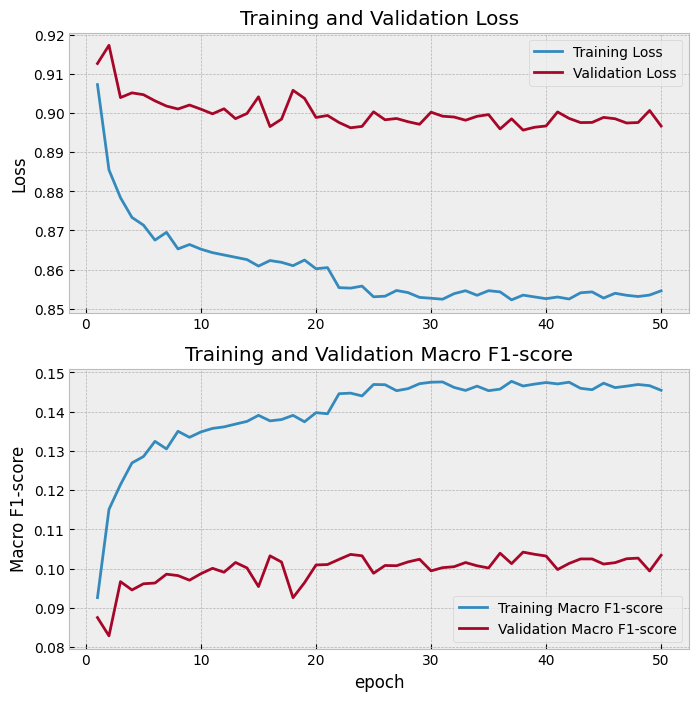

In [48]:
def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score
    for the training and validation datasets.

    Args:
        history: history callback of fitting a tensorflow keras model
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']

    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training Macro F1-score')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation Macro F1-score')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.title('Training and Validation Macro F1-score')
    plt.xlabel('epoch')

    plt.show()

    return loss, val_loss, macro_f1, val_macro_f1

losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)

# Model Testing

In [49]:
img_t = '/content/Food-Detection-10/test/IMG_20220331_134928_2_jpg.rf.4878466bab80becf14eed093b749f78f.jpg'

1/1 [==============================] - 0s 457ms/step


,class,probability
0,ayam bakar,1.000000e+00
26,terong balado,2.181257e-07
28,udang,1.828151e-24
22,steak,7.543180e-25
8,ikan goreng,1.412485e-26
20,sosis,4.513050e-30
18,roti,2.880817e-32
24,telur,6.936120e-34
17,rendang,1.099725e-34
27,tumis kangkung,3.421816e-37


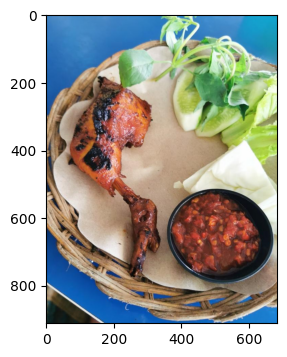

In [50]:
img = keras.preprocessing.image.load_img(img_t, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
img = keras.preprocessing.image.img_to_array(img)
img = img/255
img = np.expand_dims(img, axis=0)

prediction = model.predict(img)
pred_class = list(train_df.drop(columns=['filename']).columns)

data = {
    'class': pred_class,
    'probability': prediction[0]
}

style.use('default')
plt.figure(figsize=(8,4))
plt.imshow(Image.open(img_t))

pred_df = pd.DataFrame(data)
pred_df = pred_df.sort_values(by=['probability'], ascending=False)
pred_df[:10]

# Model Deployment

In [51]:
model.save(model_name + '.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [52]:
!pip install tensorflowjs
# !mkdir tfjs
!tensorflowjs_converter --input_format=keras /content/{model_name}.h5 /content/tfjs/{model_name}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalle

2023-12-08 05:54:49.310618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 05:54:49.310663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 05:54:49.311976: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 05:54:50.433299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [53]:
!zip -r /content/{model_name}.zip /content/tfjs/{model_name}

  adding: content/tfjs/Prototype02_B/ (stored 0%)
  adding: content/tfjs/Prototype02_B/group1-shard6of6.bin (deflated 7%)
  adding: content/tfjs/Prototype02_B/group1-shard4of6.bin (deflated 7%)
  adding: content/tfjs/Prototype02_B/group1-shard1of6.bin (deflated 7%)
  adding: content/tfjs/Prototype02_B/group1-shard2of6.bin (deflated 7%)
  adding: content/tfjs/Prototype02_B/group1-shard3of6.bin (deflated 7%)
  adding: content/tfjs/Prototype02_B/model.json (deflated 92%)
  adding: content/tfjs/Prototype02_B/group1-shard5of6.bin (deflated 7%)


In [54]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!mv /content/{model_name}.zip /content/drive/MyDrive/FONA_Model/MultiLabel
!mv /content/{model_name}.h5 /content/drive/MyDrive/FONA_Model/MultiLabel